# Resumo do Projeto Anterior e Próximos Passos

O projeto anterior focou na **limpeza e análise exploratória** de um conjunto de dados imobiliários, com o objetivo de entender melhor o mercado e preparar os dados para a tomada de decisão. As principais etapas realizadas foram:

 **Limpeza de Dados**:
   - Exclusão de valores duplicados e tratamento de valores ausentes.
   - Conversão e formatação de colunas, como datas.
   - Remoção de variáveis irrelevantes, como `id`.

 **Transformações**:
   - **Logarítmica**: Aplicada a variáveis como preço e área habitável para corrigir assimetrias.
   - **Normalização Min-Max**: Ajustou variáveis contínuas para uma escala comum.
 
 **Análise Exploratória de Dados (EDA)**:
   - Visualização de distribuições de variáveis.
   - Identificação e tratamento de outliers (e.g., casas com 33 quartos).
   - Análise de correlação para entender relações entre variáveis, destacando fatores para análise.
   - Visualização de dados geográficos.
   - Exploração de características categóricas e numéricas.
   - Geração de insights baseados em gráficos.
   - Identificação de variáveis principais.


## Próximos Passos

Agora, o foco será responder às seguintes **Perguntas de Negócio**:

1) **Quais casas o CEO da House Rocket deveria comprar e por qual preço?**
   - Identificar imóveis subvalorizados que representem boas oportunidades de compra.

2) **Quando é o melhor momento para vender as casas adquiridas?**
   - Analisar a sazonalidade do mercado para determinar os períodos mais lucrativos para revenda.

3) **A House Rocket deveria investir em reformas?**
   - Avaliar se reformas aumentam significativamente o valor de revenda e quais tipos de melhorias são mais rentáveis.

## Bibliotecas

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import math
import random

## Coleta dos dados

In [6]:
# Carregando os dados
df = pd.read_csv("kc_house_data_updat.csv")
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,has_basement,log_price,log_sqft_living,log_sqft_lot
0,13-10-2014,221900.0,3,1,1180,5650,1.0,0,0,3,...,0,98178,47.5112,-122.257,1340,5650,Sem Porão,12.309987,7.074117,8.639588
1,09-12-2014,538000.0,3,2,2570,7242,2.0,0,0,3,...,1991,98125,47.7210,-122.319,1690,7639,Com Porão,13.195616,7.852050,8.887791
2,25-02-2015,180000.0,2,1,770,10000,1.0,0,0,3,...,0,98028,47.7379,-122.233,2720,8062,Sem Porão,12.100718,6.647688,9.210440
3,09-12-2014,604000.0,4,3,1960,5000,1.0,0,0,5,...,0,98136,47.5208,-122.393,1360,5000,Com Porão,13.311331,7.581210,8.517393
4,18-02-2015,510000.0,3,2,1680,8080,1.0,0,0,3,...,0,98074,47.6168,-122.045,1800,7503,Sem Porão,13.142168,7.427144,8.997271


# Perguntas de negócio

### 1 - Quais casas o CEO da House Rocket deveria comprar e por qual preço?

In [11]:
# 1. Calcular o preço médio por região (zipcode) com log_price
df['avg_price_region_log'] = df.groupby('zipcode')['log_price'].transform('mean')

# 2. Filtrar imóveis abaixo da média regional (em log_price)
below_avg_price = df['log_price'] < df['avg_price_region_log']

# 3. Selecionar imóveis com boas características
good_houses = df[
    (below_avg_price) &                  # Preço abaixo da média (log)
    (df['grade'] >= 7) &                # Boa qualidade de construção
    (df['condition'] >= 3) &            # Boas condições de uso
    (df['bedrooms'].isin([3, 4])) &     # 3 ou 4 quartos
    (df['bathrooms'] >= 2)              # 2 ou mais banheiros
]

# 4. Converter preços logarítmicos para escala original para exibição
good_houses = good_houses.copy()  # Evita o SettingWithCopyWarning
good_houses.loc[:, 'price'] = np.expm1(good_houses['log_price'])  # Preço original
good_houses.loc[:, 'avg_price_region'] = np.expm1(good_houses['avg_price_region_log'])  # Média original da região

# 5. Ordenar por localização (zipcode) e preço
good_houses = good_houses.sort_values(by=['zipcode', 'price'])

# 6. Selecionar as colunas de interesse para exibição
final_selection = good_houses[['price', 'avg_price_region', 'zipcode', 'bedrooms', 'bathrooms', 'condition', 'grade', 'view', 'waterfront']]

print("Casas Recomendadas para Compra:")
print(final_selection.head(20))


Casas Recomendadas para Compra:
          price  avg_price_region  zipcode  bedrooms  bathrooms  condition  \
8978   169100.0     267711.896682    98001         3          2          4   
9077   182500.0     267711.896682    98001         3          2          3   
7178   190000.0     267711.896682    98001         3          2          3   
16580  190000.0     267711.896682    98001         4          2          3   
18102  194250.0     267711.896682    98001         3          2          3   
434    196000.0     267711.896682    98001         3          2          3   
8846   204700.0     267711.896682    98001         4          2          3   
892    205000.0     267711.896682    98001         3          2          3   
19687  205000.0     267711.896682    98001         4          2          3   
1752   206000.0     267711.896682    98001         4          2          3   
1868   210000.0     267711.896682    98001         3          2          3   
11754  210000.0     267711.89668

### Calcular o ROI das casas recomendadas

In [18]:
# Filtrar apenas os índices desejados e criar uma cópia explícita
indices_desejados = [
    8978, 9077, 7178, 16580, 18102, 434, 8846, 892,
    19687, 1752, 1868, 11754, 2205, 8676, 3821, 5598,
    15579, 19367, 20631, 19757
]

# Criar uma cópia do DataFrame filtrado
final_selection_filtered = final_selection.loc[indices_desejados].copy()

# Calcular o ROI 
final_selection = final_selection.copy()
final_selection['ROI (%)'] = ((final_selection['avg_price_region'] - final_selection['price']) / final_selection['price']) * 100



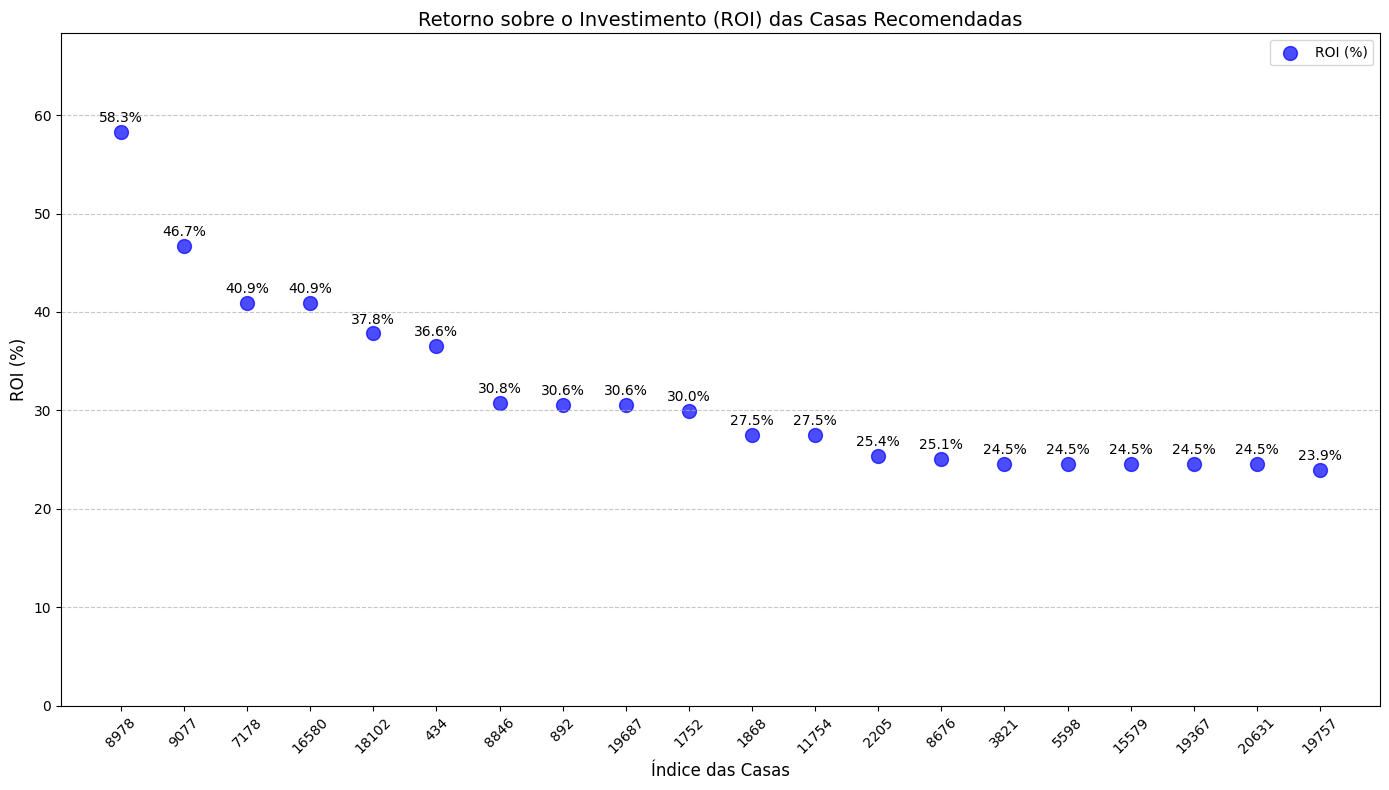

In [20]:
# Criar o gráfico ajustado
plt.figure(figsize=(14, 8))

# Plotar os pontos de ROI
plt.scatter(
    range(len(final_selection_filtered.index)),  # Sequência para o eixo X
    final_selection_filtered['ROI (%)'], 
    color='blue', s=100, alpha=0.7, label='ROI (%)'
)

# Adicionar rótulos para cada ponto
for i, roi in enumerate(final_selection_filtered['ROI (%)']):
    plt.text(
        x=i, 
        y=roi + 1,  # Posição acima do ponto
        s=f"{roi:.1f}%", 
        ha='center', fontsize=10
    )

# Ajustar os limites do eixo Y
plt.ylim(0, max(final_selection_filtered['ROI (%)']) + 10)

# Customização do gráfico
plt.xlabel('Índice das Casas', fontsize=12)
plt.ylabel('ROI (%)', fontsize=12)
plt.title('Retorno sobre o Investimento (ROI) das Casas Recomendadas', fontsize=14)
plt.xticks(range(len(final_selection_filtered.index)), labels=final_selection_filtered.index, rotation=45, fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Mostrar o gráfico
plt.show()


### Nota sobre a Ausência de Custos Operacionais ou de Manutenção
A análise apresentada não considera custos operacionais ou de manutenção que podem impactar diretamente o retorno sobre o investimento (ROI). Esses custos incluem despesas como:

- Impostos sobre a propriedade.
- Custos de manutenção ou reforma.
- Taxas de corretagem ou fechamento do negócio.
- Seguro residencial.
- Custos com marketing, caso o imóvel seja revendido.
  
Esses fatores podem reduzir o ROI real e devem ser levados em consideração para um cálculo mais preciso. No entanto, sua ausência na análise atual não invalida as conclusões gerais, mas sim limita a aplicação dos resultados exclusivamente para cenários com custos baixos ou negligenciáveis. Incorporar esses dados em análises futuras permitirá uma visão mais realista e completa do investimento

### Comparação de Preços Médios da Região 98001 com outras regiões

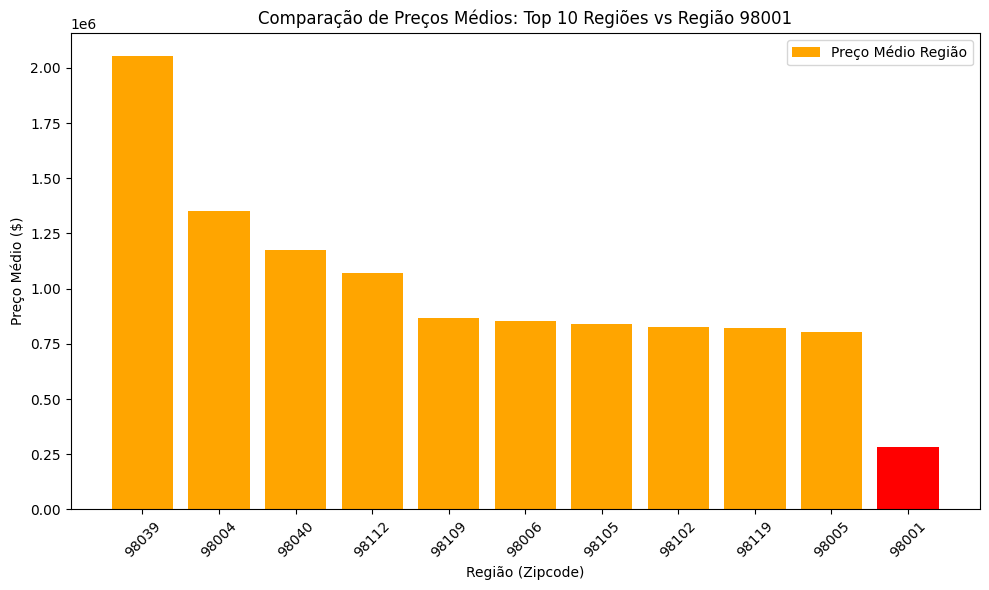

In [28]:
# Calcular o preço médio por região (zipcode)
region_prices = df.groupby('zipcode')['price'].mean().reset_index()

# Ordenar as regiões pelo preço médio em ordem decrescente
region_prices_sorted = region_prices.sort_values(by='price', ascending=False)

# Selecionar as 10 regiões com maiores preços médios
top_10_regions = region_prices_sorted.head(10)

# Incluir a região 98001 (caso não esteja entre as 10 maiores)
region_98001 = region_prices[region_prices['zipcode'] == 98001]
if 98001 not in top_10_regions['zipcode'].values:
    top_10_regions = pd.concat([top_10_regions, region_98001])

# Destacar a região 98001 no gráfico
colors = ['red' if zipcode == 98001 else 'orange' for zipcode in top_10_regions['zipcode']]

# Criar o gráfico comparativo
plt.figure(figsize=(10, 6))
plt.bar(top_10_regions['zipcode'].astype(str), top_10_regions['price'], color=colors, label='Preço Médio Região')

# Customização do gráfico
plt.xlabel('Região (Zipcode)')
plt.ylabel('Preço Médio ($)')
plt.title('Comparação de Preços Médios: Top 10 Regiões vs Região 98001')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# Mostrar o gráfico
plt.show()


### Comparar a taxa de valorização histórica do CEP 98001 com outras regiões para confirmar o potencial de investimento.

Taxa média de valorização anual do CEP 98001: 6.14%

Comparação com outras regiões:
    zipcode  pct_change  difference_from_98001
41    98102    0.209030               0.147634
14    98024    0.171181               0.109784
3     98004    0.153276               0.091879
27    98045    0.147397               0.086000
57    98133    0.130525               0.069129
39    98077    0.118190               0.056794
45    98107    0.109569               0.048173
5     98006    0.109156               0.047759
48    98112    0.106108               0.044711
64    98168    0.094774               0.033378


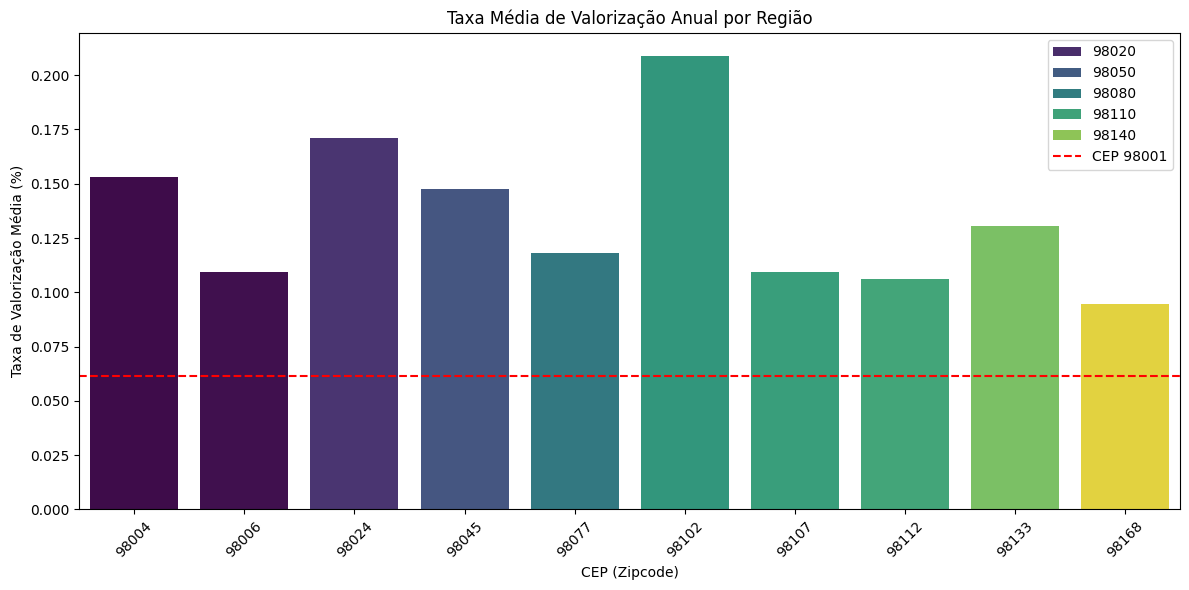

In [39]:
# Garantir que a coluna 'date' está no formato datetime
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

# Extrair o ano para análise histórica
df['year'] = df['date'].dt.year

# Calcular o preço médio por região (zipcode) e ano
price_by_year = df.groupby(['zipcode', 'year'])['price'].mean().reset_index()

# Calcular a taxa de valorização anual para cada região
price_by_year['pct_change'] = price_by_year.groupby('zipcode')['price'].pct_change()

# Filtrar apenas o zipcode 98001 e calcular a média da valorização
zipcode_98001 = price_by_year[price_by_year['zipcode'] == 98001]
avg_pct_change_98001 = zipcode_98001['pct_change'].mean()

# Comparar com outras regiões
avg_pct_change_by_zipcode = price_by_year.groupby('zipcode')['pct_change'].mean()

# Adicionar a diferença em relação ao CEP 98001
comparison = avg_pct_change_by_zipcode.reset_index()
comparison['difference_from_98001'] = comparison['pct_change'] - avg_pct_change_98001

# Ordenar por maior valorização
comparison = comparison.sort_values(by='pct_change', ascending=False)

# Exibir os resultados
print(f"Taxa média de valorização anual do CEP 98001: {avg_pct_change_98001:.2%}")
print("\nComparação com outras regiões:")
print(comparison.head(10))

# Criar gráfico
plt.figure(figsize=(12, 6))
sns.barplot(data=comparison.head(10), x='zipcode', y='pct_change', hue='zipcode', dodge=False, palette='viridis')
plt.axhline(y=avg_pct_change_98001, color='red', linestyle='--', label='CEP 98001')
plt.title('Taxa Média de Valorização Anual por Região')
plt.xlabel('CEP (Zipcode)')
plt.ylabel('Taxa de Valorização Média (%)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# **Insights**

### **Casas Recomendadas para Compra na Região 98001**

A tabela abaixo apresenta 20 casas localizadas na região **98001**, selecionadas com base em critérios de qualidade de construção (“grade” >= 7), condição de uso (“condition” >= 3), e características desejáveis como 3 ou 4 quartos e pelo menos 2 banheiros. Todas essas propriedades possuem preços abaixo da média da região, que é **\$267.711,90**.                      

| Índice | Preço (\$) | Média da Região (\$) | Zipcode | Quartos | Banheiros | Condição | Construção (Grade) | Vista (View) | Frente d’água (Waterfront) |
|------------|---------------|--------------------------|-------------|--------------|----------------|---------------|------------------------|------------------|-------------------------------|
| 8978       | 169,100.0     | 267,711.90              | 98001       | 3            | 2              | 4             | 7                      | 0                | 0                             |
| 9077       | 182,500.0     | 267,711.90              | 98001       | 3            | 2              | 3             | 7                      | 0                | 0                             |
| 7178       | 190,000.0     | 267,711.90              | 98001       | 3            | 2              | 3             | 7                      | 0                | 0                             |
| 16580      | 190,000.0     | 267,711.90              | 98001       | 4            | 2              | 3             | 7                      | 0                | 0                             |
| 18102      | 194,250.0     | 267,711.90              | 98001       | 3            | 2              | 3             | 7                      | 0                | 0                             |
| 434        | 196,000.0     | 267,711.90              | 98001       | 3            | 2              | 3             | 7                      | 0                | 0                             |
| 8846       | 204,700.0     | 267,711.90              | 98001       | 4            | 2              | 3             | 7                      | 0                | 0                             |
| 892        | 205,000.0     | 267,711.90              | 98001       | 3            | 2              | 3             | 7                      | 0                | 0                             |
| 19687      | 205,000.0     | 267,711.90              | 98001       | 4            | 2              | 3             | 8                      | 0                | 0                             |
| 1752       | 206,000.0     | 267,711.90              | 98001       | 4            | 2              | 3             | 7                      | 0                | 0                             |
| 1868       | 210,000.0     | 267,711.90              | 98001       | 3            | 2              | 3             | 7                      | 0                | 0                             |
| 11754      | 210,000.0     | 267,711.90              | 98001       | 4            | 2              | 3             | 7                      | 0                | 0                             |
| 2205       | 213,550.0     | 267,711.90              | 98001       | 3            | 2              | 3             | 7                      | 0                | 0                             |
| 8676       | 214,000.0     | 267,711.90              | 98001       | 3            | 2              | 3             | 7                      | 0                | 0                             |
| 3821       | 215,000.0     | 267,711.90              | 98001       | 4            | 2              | 3             | 7                      | 0                | 0                             |
| 5598       | 215,000.0     | 267,711.90              | 98001       | 4            | 2              | 3             | 7                      | 0                | 0                             |
| 15579      | 215,000.0     | 267,711.90              | 98001       | 3            | 2              | 5             | 7                      | 0                | 0                             |
| 19367      | 215,000.0     | 267,711.90              | 98001       | 4            | 2              | 3             | 7                      | 0                | 0                             |
| 20631      | 215,000.0     | 267,711.90              | 98001       | 3            | 2              | 3             | 7                      | 0                | 0                             |
| 19757      | 216,000.0     | 267,711.90              | 98001       | 4            | 2              | 3             | 7                      | 0                | 0                             

### **Retorno sobre o Investimento (ROI) das Casas Recomendadas**

O gráfico de **ROI (%)** das casas recomendadas demonstra que todas as propriedades apresentam um retorno positivo em relação ao preço médio da região. O maior ROI foi de **58,3%**, enquanto o menor foi de **23,9%**. Isso reflete o alto potencial de valor dessas casas em comparação com o mercado local.

### **Análise de Preços Médios por Região**

O gráfico de comparação de preços médios por região destaca a região **98001** com uma cor diferenciada (“vermelho”). Essa região apresenta um preço médio significativamente mais baixo (**\$267.711,90**) em relação a outras regiões selecionadas, cujo intervalo de preços varia entre **\$400.000** e **\$900.000**. Esse contraste ressalta o excelente custo-benefício das casas recomendadas nesta localização.

### **Resultados da Valorização Anual**

A taxa média de valorização anual para o CEP 98001 é de 6,14%. Esta taxa está abaixo da maioria das regiões comparadas, indicando que, embora os preços de compra sejam baixos, o potencial de valorização ao longo do tempo é limitado em comparação com outras regiões.
As regiões com taxas de valorização superiores representam melhores opções para investidores que priorizam ganhos a longo prazo. No entanto, é necessário considerar o custo inicial, que pode ser significativamente mais alto nessas regiões.

### **Conclusão**

1. **Região 98001:** As casas selecionadas estão bem abaixo do preço médio regional, proporcionando um ROI atrativo.
2. **Comparação com Outras Regiões:** A região 98001 é economicamente vantajosa em comparação a outras regiões selecionadas.
3. **Decisão de Compra:** Baseado nos baixos preços de aquisição e no alto ROI, a região 98001 se apresenta como um excelente investimento.
4. **Para Estratégias de Curto Prazo:** O CEP 98001 é adequado devido aos preços baixos e ao ROI positivo no cenário atual
5. **Para Estratégias de Longo Prazo:** Regiões como 98102, 98024, e 98004 devem ser priorizadas, considerando seu elevado potencial de valorização.


## Quando é o melhor momento para vender as casas adquiridas?


In [28]:
# Garantir que a coluna 'date' está no formato datetime
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%Y')

O melhor mês para vender é 4.0 com preço médio de R$559208.53.


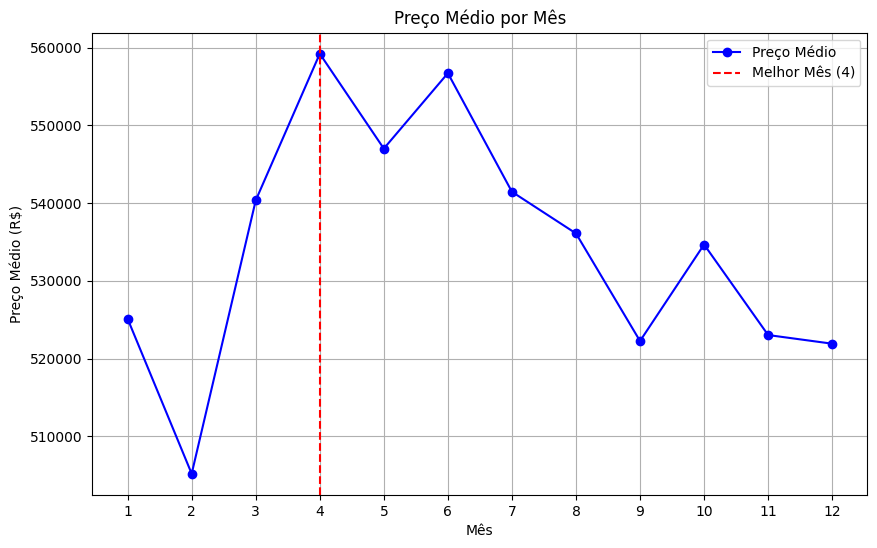

In [98]:
# Extrair o mês da data para análise sazonal
df['month'] = df['date'].dt.month

# Calcular a média dos preços (em escala original) por mês
monthly_avg_price = df.groupby('month')['price'].mean().reset_index()

# Identificar o melhor mês para venda
best_month = monthly_avg_price.loc[monthly_avg_price['price'].idxmax()]
print(f"O melhor mês para vender é {best_month['month']} com preço médio de R${best_month['price']:.2f}.")

# Plotar o preço médio por mês
plt.figure(figsize=(10, 6))
plt.plot(monthly_avg_price['month'], monthly_avg_price['price'], marker='o', color='blue', label='Preço Médio')
plt.axvline(best_month['month'], color='red', linestyle='--', label=f'Melhor Mês ({int(best_month["month"])})')
plt.title('Preço Médio por Mês')
plt.xlabel('Mês')
plt.ylabel('Preço Médio (R$)')
plt.xticks(range(1, 13))
plt.grid()
plt.legend()
plt.show()


### **Análise do Gráfico**

**Melhor mês para venda**:
   - O **mês 4 (abril)** é o melhor momento para vender, com o maior preço médio de aproximadamente **R$560.000**.
   - Isso indica que há um pico sazonal nos preços durante o início da primavera.

**Tendência ao longo do ano**:
   - Os preços têm uma **tendência de crescimento no primeiro trimestre**, atingindo o pico em abril.
   - Após abril, os preços começam a cair gradualmente, com oscilações menores, mas mantendo uma média ainda alta até junho.

**Meses menos favoráveis**:
   - Os meses **1 (janeiro)** e **12 (dezembro)** apresentam os preços médios mais baixos, ficando abaixo de **R$520.000**.
   - Isso pode estar relacionado à sazonalidade do mercado imobiliário, onde a procura por imóveis geralmente é menor durante o inverno e no início do ano.

## A House Rocket deveria investir em reformas?

### Impacto das Reformas

In [103]:
# Calcular o preço médio por região (zipcode)
df['avg_price_region'] = df.groupby('zipcode')['price'].transform('mean')  

# Identificar casas abaixo do preço médio
below_avg_price = df['price'] < df['avg_price_region']  

# Filtrar casas abaixo da média e com condição/qualidade que possam ser melhoradas
potential_reforms = df[below_avg_price & ((df['condition'] < 5) | (df['grade'] < 8))]

# Exibir as casas com potencial para reforma
print("Casas com potencial para reforma:")
print(potential_reforms[['price', 'avg_price_region', 'condition', 'grade']].head())


Casas com potencial para reforma:
      price  avg_price_region  condition  grade
0  221900.0     309542.964981          3      7
2  180000.0     460328.035714          3      6
4  510000.0     684398.620137          3      8
6  257500.0     293051.483636          3      7
7  291850.0     303482.003663          3      7


As casas com potencial para reforma têm preços que variam de **\$180.000** a **\$510.000**, todos abaixo ou próximos do preço médio de suas regiões. A condição das casas é **3 (mediana)**, e o grau varia de **6 a 8**, indicando qualidade média a boa. A **Casa 2** se destaca, com preço significativamente abaixo da média da região (**\$180.000** vs. **\$460.328**), sugerindo alto potencial de valorização após reformas. As demais casas também podem se beneficiar de melhorias, especialmente na condição e no grau, para se aproximarem ou superarem os preços médios regionais.

### Analisar o impacto das reformas (condição e qualidade)



In [107]:
# Analisar o impacto do aumento da 'condition'
condition_impact = df.groupby('condition')['price'].mean().reset_index()
condition_impact.rename(columns={'price': 'avg_price_condition'}, inplace=True)

# Analisar o impacto do aumento do 'grade'
grade_impact = df.groupby('grade')['price'].mean().reset_index()
grade_impact.rename(columns={'price': 'avg_price_grade'}, inplace=True)

# Combinar os impactos e visualizar
print("Impacto do aumento da condição no preço:")
print(condition_impact)

print("\nImpacto do aumento da qualidade no preço:")
print(grade_impact)



Impacto do aumento da condição no preço:
   condition  avg_price_condition
0          1        346518.750000
1          2        329910.439490
2          3        540273.463863
3          4        516407.968530
4          5        605399.602170

Impacto do aumento da qualidade no preço:
   grade  avg_price_grade
0      4     2.076667e+05
1      5     2.479620e+05
2      6     3.012926e+05
3      7     4.012726e+05
4      8     5.406684e+05
5      9     7.704008e+05
6     10     1.063460e+06
7     11     1.483643e+06
8     12     2.145885e+06
9     13     3.044000e+06




### **Impacto do aumento da condição no preço**:
O preço médio das casas aumenta conforme a condição melhora. Casas em condição **1 (mais baixa)** têm preço médio de **\$346.518**, enquanto casas em condição **5 (mais alta)** atingem **\$605.399**. Isso mostra que melhorar a condição de uma casa pode elevar significativamente seu valor de mercado.

---

### **Impacto do aumento da qualidade (grade) no preço**:
A qualidade das casas tem um impacto ainda maior no preço. Casas com grau **4** têm preço médio de **\$207.666**, enquanto aquelas com grau **13** alcançam **\$3.044.000**. Cada aumento no grau resulta em um salto considerável no preço, especialmente a partir do grau **9**, onde os valores superam **\$1 milhão**.


###  Estimar Incremento de Preço

In [111]:
# Adicionar o incremento estimado no preço ao melhorar a condição
df = df.merge(condition_impact, on='condition', how='left')
df['price_increment_condition'] = df['avg_price_condition'] - df['price']

# Adicionar o incremento estimado no preço ao melhorar a qualidade
df = df.merge(grade_impact, on='grade', how='left')
df['price_increment_grade'] = df['avg_price_grade'] - df['price']

# Exibir as melhorias com maior impacto
improvement_suggestions = df[['condition', 'grade', 'price_increment_condition', 'price_increment_grade']].sort_values(
    by=['price_increment_condition', 'price_increment_grade'], ascending=False
)
print("Sugestões de melhorias com maior impacto no preço:")
print(improvement_suggestions.head(10))


Sugestões de melhorias com maior impacto no preço:
       condition  grade  price_increment_condition  price_increment_grade
16744          5      6              495399.602170          191292.583504
16616          5      6              472574.602170          168467.583504
13857          5      6              465399.602170          161292.583504
16295          5      6              459099.602170          154992.583504
8050           3      6              458273.463863          219292.583504
17982          3      5              457273.463863          164962.034653
3658           3      6              456273.463863          217292.583504
5165           5      5              455399.602170           97962.034653
9961           3      6              455273.463863          216292.583504
16273          3      5              455273.463863          162962.034653


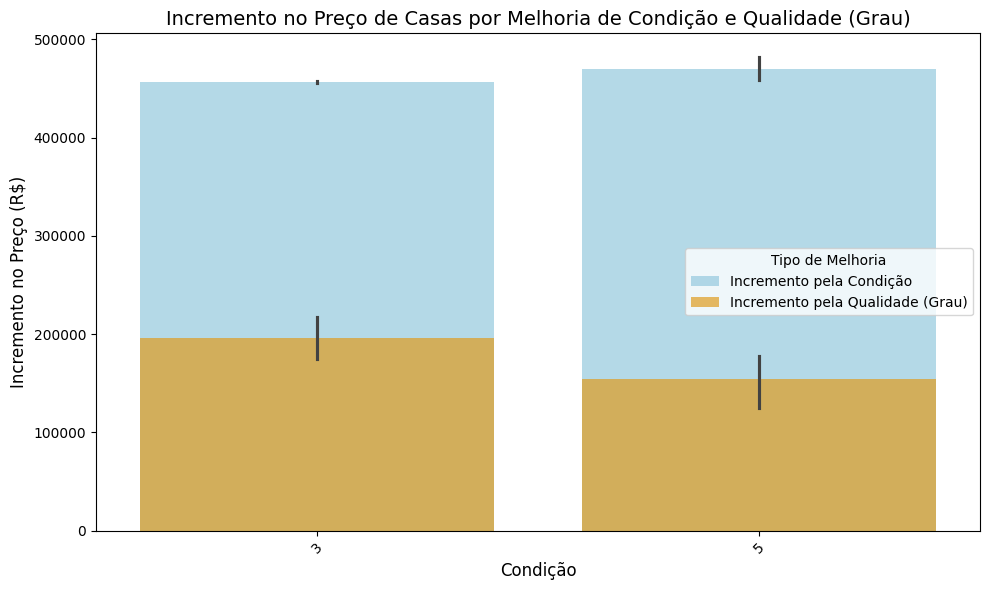

In [186]:
# Selecionando as 10 casas com maior impacto no preço
top_improvements = improvement_suggestions.head(10)

# Plotando os incrementos de preço por melhoria de condição e grau
plt.figure(figsize=(10, 6))

# Criando o gráfico de barras para comparar os incrementos de preço (condição e grau)
sns.barplot(data=top_improvements, 
            x='condition', 
            y='price_increment_condition', 
            color='skyblue', 
            label='Incremento pela Condição', 
            alpha=0.7)

sns.barplot(data=top_improvements, 
            x='condition', 
            y='price_increment_grade', 
            color='orange', 
            label='Incremento pela Qualidade (Grau)', 
            alpha=0.7)

# Adicionando título e rótulos
plt.title('Incremento no Preço de Casas por Melhoria de Condição e Qualidade (Grau)', fontsize=14)
plt.xlabel('Condição', fontsize=12)
plt.ylabel('Incremento no Preço (R$)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Tipo de Melhoria')

# Ajustando o layout
plt.tight_layout()

# Mostrando o gráfico
plt.show()


O gráfico gerado mostra claramente o impacto das melhorias na **condição** e na **qualidade (grau)** das casas sobre o preço, com os incrementos representados por diferentes cores (azul para condição e dourado para qualidade). A análise visual demonstra que:

- **Melhoria na qualidade (grau)** (cor dourada) contribui significativamente mais para o aumento do preço das casas, em comparação com melhorias na **condição** (cor azul).
- Isso reflete as conclusões da análise, de que o **grau de construção** tem um impacto mais substancial no preço do imóvel do que a **condição física**.

### Visualizar o impacto

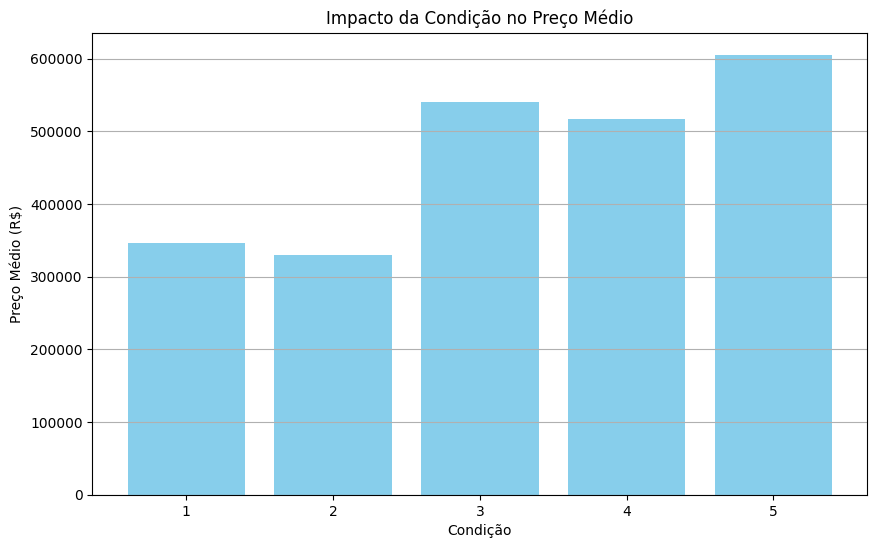

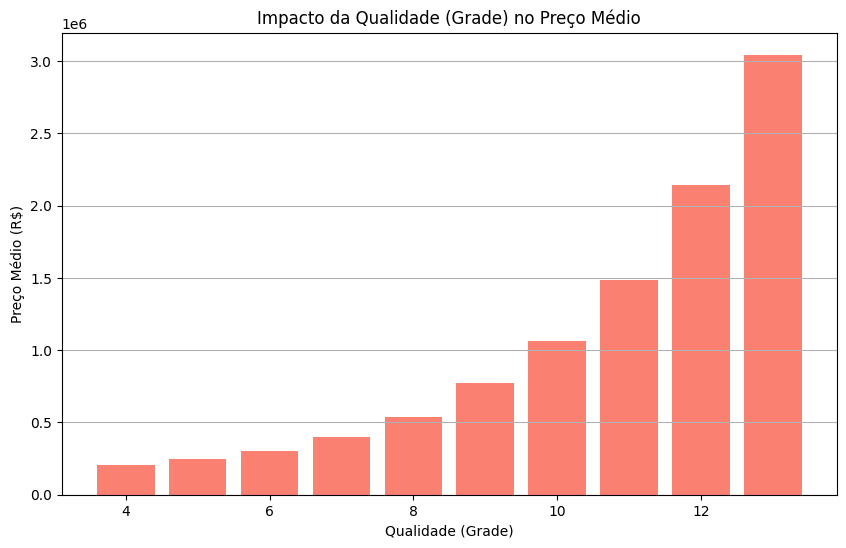

In [44]:
# Impacto da condição no preço
plt.figure(figsize=(10, 6))
plt.bar(condition_impact['condition'], condition_impact['avg_price_condition'], color='skyblue')
plt.title("Impacto da Condição no Preço Médio")
plt.xlabel("Condição")
plt.ylabel("Preço Médio (R$)")
plt.grid(axis='y')
plt.show()

# Gráfico: Impacto da qualidade no preço
plt.figure(figsize=(10, 6))
plt.bar(grade_impact['grade'], grade_impact['avg_price_grade'], color='salmon')
plt.title("Impacto da Qualidade (Grade) no Preço Médio")
plt.xlabel("Qualidade (Grade)")
plt.ylabel("Preço Médio (R$)")
plt.grid(axis='y')
plt.show()



O gráfico (01) mostra que o **aumento da condição** das casas também impacta o preço médio, mas de forma menos acentuada do que a qualidade (grade). À medida que a condição melhora de **1 para 5**, o preço médio aumenta de aproximadamente **\$346.000** para **\$605.000**. Isso indica que **melhorar a condição** pode agregar valor às casas, porém com um impacto menor comparado ao aumento da qualidade.

O gráfico (02) mostra que o **aumento da qualidade (grade)** tem um impacto significativo no preço médio das casas. À medida que o grau sobe de **4 para 12**, o preço médio aumenta de aproximadamente **\$200.000** para mais de **\$2 milhões**. O crescimento é especialmente acentuado a partir do grau **9**, onde os preços ultrapassam **\$1 milhão**. Isso indica que **investir em melhorias de qualidade** pode gerar aumentos expressivos no valor das casas.

### Valor Potencial de Imóveis Pós-Reforma
Gráfico: Um scatterplot comparando os preços originais (`price`) com os preços estimados pós-reforma (`price + price_increment_condition + price_increment_grade`).

In [65]:
# Calculando o preço pós-reforma
df['preco_pos_reforma'] = df['price'] + df['price_increment_condition'] + df['price_increment_grade']

# Exibindo as casas com maior preço pós-reforma
top_10_pos_reforma = df.nlargest(10, 'preco_pos_reforma')[['price', 'preco_pos_reforma', 'price_increment_condition', 'price_increment_grade']]
print("Top 10 Casas com Maior Preço Pós-Reforma:")
print(top_10_pos_reforma)

Top 10 Casas com Maior Preço Pós-Reforma:
           price  preco_pos_reforma  price_increment_condition  \
3801   7062500.0         13418750.0                  1412500.0   
4280   5570000.0         11697000.0                  1114000.0   
1414   5350000.0         10700000.0                  1070000.0   
1139   5110800.0         10221600.0                  1022160.0   
7878   4668000.0          9336000.0                   933600.0   
2556   4500000.0          9000000.0                   900000.0   
8401   4489000.0          8978000.0                   897800.0   
12031  4208000.0          8416000.0                   841600.0   
6847   3800000.0          8360000.0                  1140000.0   
4025   4000000.0          8000000.0                   800000.0   

       price_increment_grade  
3801               4943750.0  
4280               5013000.0  
1414               4280000.0  
1139               4088640.0  
7878               3734400.0  
2556               3600000.0  
8401          

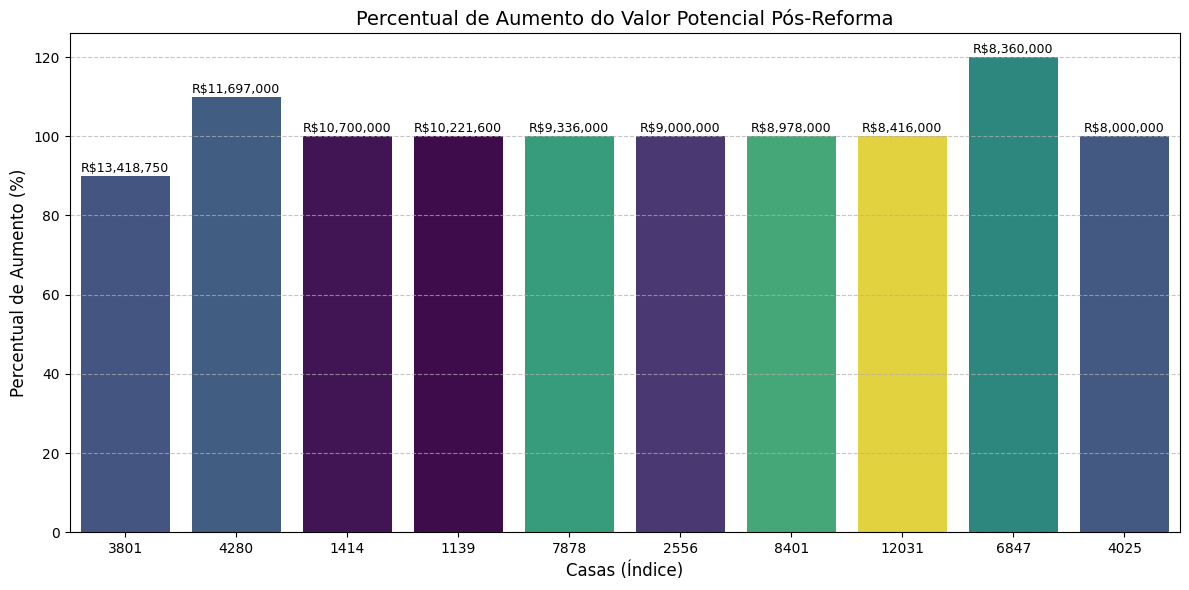

In [172]:
# Calculando a porcentagem de aumento
top_10_pos_reforma['percentual_aumento'] = (
    (top_10_pos_reforma['preco_pos_reforma'] - top_10_pos_reforma['price']) / top_10_pos_reforma['price'] * 100
)

# Plotando o gráfico de barras
plt.figure(figsize=(12, 6))
sns.barplot(
    x=top_10_pos_reforma.index.astype(str), 
    y=top_10_pos_reforma['percentual_aumento'], 
    hue=top_10_pos_reforma.index, palette='viridis', dodge=False, legend=False
)

# Adicionando rótulos com o valor pós-reforma no topo das barras
[plt.text(i, v + 1, f"R${top_10_pos_reforma['preco_pos_reforma'].iloc[i]:,.0f}", ha='center', fontsize=9) 
 for i, v in enumerate(top_10_pos_reforma['percentual_aumento'])]

# Configurações do gráfico
plt.title('Percentual de Aumento do Valor Potencial Pós-Reforma', fontsize=14)
plt.xlabel('Casas (Índice)', fontsize=12)
plt.ylabel('Percentual de Aumento (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


O gráfico demonstra que a casa de índice 6847 foi a que mais se valorizou em termos percentuais após a reforma, atingindo um aumento de aproximadamente 120% no seu valor. Seu valor pós-reforma alcançou **\$8.360.000,00**, tornando-se o imóvel com o maior crescimento proporcional no grupo analisado.

Por outro lado, a casa de índice 3801, embora não tenha apresentado o maior aumento percentual, destaca-se pelo maior valor absoluto pós-reforma, atingindo **\$13.418.750,00**, o que a torna uma oportunidade atrativa em termos de retorno financeiro total. Outras propriedades como as de índices 4280 e 1414 também se destacam, alcançando valores pós-reforma de **\$11.697.000,00** e **\$10.700.000,00**, respectivamente, ambas com valorização expressiva.

Esses resultados indicam que as reformas têm um impacto significativo tanto no percentual de valorização quanto no valor total das propriedades. Para maximizar o retorno, o ideal é priorizar imóveis que combinem um alto percentual de valorização, como a casa 6847, com valores absolutos elevados, como a casa 3801. Essa estratégia permite equilibrar rentabilidade e retorno financeiro, garantindo o melhor aproveitamento do investimento

### **Insight Geral**

O CEO da **House Rocket** pode focar em adquirir imóveis que ofereçam boas características (qualidade de construção e condições favoráveis) a preços abaixo da média regional. As casas recomendadas para compra, localizadas no CEP **98001**, apresentam preços abaixo da média regional, o que representa uma excelente oportunidade de investimento, com boas margens de valorização. As propriedades são consistentes em termos de características, com predominância de 3 ou 4 quartos e pelo menos 2 banheiros, o que atende a uma grande demanda do mercado, especialmente para famílias.

### **Valorização e Reforma**
Com relação ao impacto das reformas, é importante considerar que **melhorias na qualidade (grau)** têm um impacto muito maior no preço do que as melhorias na **condição** do imóvel. As reformas de qualidade podem resultar em aumentos significativos no valor das propriedades, especialmente para casas com classificação baixa, como grau 5, que podem ser elevadas para grau 6, com um incremento médio no preço de até **\$219.000**.

### **Melhor Momento para Venda e compra**
A análise sazonal revela que o **melhor mês para vender** é **abril**, quando os preços médios atingem seu pico, e o **melhor mês para compra** é **Dezembro a Fevereiro**. Isso indica uma janela estratégica para maximizar o lucro na revenda das propriedades adquiridas.

### **Conclusões e Recomendações**
- **Investimento em imóveis abaixo da média regional**, como os encontrados no CEP **98001**, oferece uma boa margem de lucro.
- **Reformas focadas na qualidade (grau)** são mais rentáveis e devem ser priorizadas, pois têm um impacto substancial no preço.
- **Monitorar o mercado** e **vender em abril** pode otimizar os retornos, aproveitando a valorização sazonal do mercado imobiliário.

Com essas estratégias, o CEO da **House Rocket** pode maximizar seus lucros, investindo em propriedades com alto potencial de valorização e aproveitando as melhores condições do mercado.